In [1]:
#Used some text cleaning method from Muhammad Alfiansyah's kernel here: https://www.kaggle.com/muhammadalfiansyah/push-the-lgbm-v19
import xgboost as xgb
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc 
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

NFOLDS = 5
SEED = 42
VALID = True
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None, seed_bool = True):
        if(seed_bool == True):
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
        
def get_oof(clf, x_train, y, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
    
def cleanName(text):
    try:
        textProc = text.lower()
        # textProc = " ".join(map(str.strip, re.split('(\d+)',textProc)))
        #regex = re.compile(u'[^[:alpha:]]')
        #textProc = regex.sub(" ", textProc)
        textProc = re.sub('[!@#$_“”¨«»®´·º½¾¿¡§£₤‘’]', '', textProc)
        textProc = " ".join(textProc.split())
        return textProc
    except: 
        return "name error"
 

def rmse(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power((y - y0), 2)))

print("\nData Load Stage")
training = pd.read_csv('train.csv.zip', index_col = "item_id", parse_dates = ["activation_date"])


/home/dex/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)



Data Load Stage


In [2]:
training_img = pd.read_csv('train_img_features_v1.csv',index_col = "item_id")
test_img = pd.read_csv('test_img_features_v1.csv',index_col = "item_id")

In [3]:
#training = training[training.description.isnull() == False]

In [4]:
traindex = training.index
testing = pd.read_csv('test.csv.zip', index_col = "item_id", parse_dates = ["activation_date"])
testdex = testing.index

gp = pd.read_csv('aggregated_features.csv') 
training = training.merge(gp, on='user_id', how='left')
testing = testing.merge(gp, on='user_id', how='left')
 
training.index = traindex
testing.index =testdex
training = training.merge(training_img, left_index=True, right_index=True)
testing = testing.merge(test_img, left_index=True, right_index=True)



agg_cols = list(gp.columns)[1:]

del gp,training_img,test_img
gc.collect()

119

In [5]:
ntrain = training.shape[0]
ntest = testing.shape[0]

kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=SEED)

y = training.deal_probability.copy()
training.drop("deal_probability",axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))

print("Combine Train and Test")
df = pd.concat([training,testing],axis=0)
del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

Train shape: 1503424 Rows, 30 Columns
Test shape: 508438 Rows, 30 Columns
Combine Train and Test

All Data shape: 2011862 Rows, 30 Columns


In [6]:
df['image'] =df['image_x']
df.drop(['image_x', 'image_y'], axis = 1, inplace  = True)

In [7]:
df['has_image'] = 1
df.loc[df['image'].isnull(), 'has_image'] = 0

df['price_is_null'] = 0
df.loc[df['price'].isnull(), 'price_is_null'] = 1

df['param_1_is_null'] = 0
df.loc[df['param_1'].isnull(), 'param_1_is_null'] = 1
df['param_2_is_null'] = 0
df.loc[df['param_2'].isnull(), 'param_2_is_null'] = 1
df['param_3_is_null'] = 0
df.loc[df['param_3'].isnull(), 'param_3_is_null'] = 1
df['image_top_1_is_null'] = 0

In [8]:
df['description'] = df['description'].apply(lambda x: str(x).replace('/\n', ' ').replace('\xa0', ' ').replace('.', '. ').replace(',', ', '))

In [9]:
for col in agg_cols:
    df[col].fillna(-1, inplace=True)

print("Feature Engineering")
df["price"] = np.log(df["price"]+0.001)
df["price"].fillna(df.price.mean(),inplace=True)
df["image_top_1"].fillna(-999,inplace=True)

print("\nCreate Time Variables")
df["Weekday"] = df['activation_date'].dt.weekday 
training_index = df.loc[df.activation_date<=pd.to_datetime('2017-04-07')].index
validation_index = df.loc[df.activation_date>=pd.to_datetime('2017-04-08')].index
df.drop(["activation_date","image"],axis=1,inplace=True)

print("\nEncode Variables")
categorical = ["user_id","region","city","parent_category_name","category_name","user_type","image_top_1","param_1","param_2","param_3"]
print("Encoding :",categorical)

# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical:
    df[col].fillna('Unknown')
    df[col] = lbl.fit_transform(df[col].astype(str))
    
#X = hstack([csr_matrix(df.loc[traindex,:].values),ready_df[0:traindex.shape[0]]]) # Sparse Matrix
#testing = hstack([csr_matrix(df.loc[testdex,:].values),ready_df[traindex.shape[0]:]])


Feature Engineering

Create Time Variables


/home/dex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """



Encode Variables
Encoding : ['user_id', 'region', 'city', 'parent_category_name', 'category_name', 'user_type', 'image_top_1', 'param_1', 'param_2', 'param_3']


In [10]:
print("\nText Features")

# Feature Engineering 

# Meta Text Features
textfeats = ["description", "title"]
#df['desc_punc'] = df['description'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

df['title'] = df['title'].apply(lambda x: cleanName(x))
df["description"]   = df["description"].apply(lambda x: cleanName(x))

for cols in textfeats:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].astype(str).fillna('missing') # FILL NA
    df[cols + "count_words_upper"] = df[cols].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words
    #Letter count
    df[cols + '_count_letters']=df[cols].apply(lambda x: len(str(x)))
    #punctuation count
    df[cols + "count_punctuations"] = df[cols].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    #title case words count
    df[cols + "count_words_title"] = df[cols].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    #Number of stopwords
    #df[cols + "count_stopwords"] = df[cols].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('russian')]))
    #Average length of the words
    df[cols + "mean_word_len"] = df[cols].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    df[cols + "english_letters"] = df[cols].apply(lambda x: len([c for c in str(x) if c in string.ascii_letters]))
    df[cols + "english_prop_letters"] = df[cols + "english_letters"]/df[cols + '_count_letters']
    

df['words_vs_unique_description'] = df['description_num_unique_words'] / df['description_num_words'] * 100
df['title_desc_len_ratio'] = df['title_count_letters']/df['description_count_letters']


df['len_description'] = df['description'].apply(lambda x: len(x)) 
df['average_description_word_length'] = df['len_description'] / df['description_num_words']

print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
russian_stop = set(stopwords.words('russian'))



def get_col(col_name): return lambda x: x[col_name]
##I added to the max_features of the description. It did not change my score much but it may be worth investigating

    
start_vect=time.time()

# Drop Text Cols
textfeats = ["description", "title"]
df.drop(textfeats, axis=1,inplace=True)

from sklearn.metrics import mean_squared_error
from math import sqrt



Text Features


/home/dex/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)



[TF-IDF] Term Frequency Inverse Document Frequency Stage


In [11]:
train_f = pd.read_csv('train_all_features.csv')[['svd_title_1', 'svd_title_2', 'svd_title_3', 'svd_title_4',
       'svd_title_5', 'svd_title_6', 'svd_title_7', 'svd_title_8',
       'svd_title_9', 'svd_title_10', 'svd_description_1', 'svd_description_2',
       'svd_description_3', 'svd_description_4', 'svd_description_5',
       'svd_description_6', 'svd_description_7', 'svd_description_8',
       'svd_description_9', 'svd_description_10',  'svd_text_1',
       'svd_text_2', 'svd_text_3', 'svd_text_4', 'svd_text_5', 'svd_text_6',
       'svd_text_7', 'svd_text_8', 'svd_text_9', 'svd_text_10']]
test_f = pd.read_csv('test_all_features.csv')[['svd_title_1', 'svd_title_2', 'svd_title_3', 'svd_title_4',
       'svd_title_5', 'svd_title_6', 'svd_title_7', 'svd_title_8',
       'svd_title_9', 'svd_title_10', 'svd_description_1', 'svd_description_2',
       'svd_description_3', 'svd_description_4', 'svd_description_5',
       'svd_description_6', 'svd_description_7', 'svd_description_8',
       'svd_description_9', 'svd_description_10',  'svd_text_1',
       'svd_text_2', 'svd_text_3', 'svd_text_4', 'svd_text_5', 'svd_text_6',
       'svd_text_7', 'svd_text_8', 'svd_text_9', 'svd_text_10']]

In [12]:
svd_feat = train_f.append(test_f, ignore_index=True)
del train_f, test_f
gc.collect()

54

In [13]:
svd_feat.index = df.index

In [14]:
df = df.merge(svd_feat, left_index=True, right_index=True, how='inner') 

In [15]:
cols = ['resnet_nima_feature_0', 'resnet_nima_feature_1',
       'resnet_nima_feature_2', 'resnet_nima_feature_3',
       'resnet_nima_feature_4', 'resnet_nima_feature_5',
       'resnet_nima_feature_6', 'resnet_nima_feature_7',
       'resnet_nima_feature_8', 'resnet_nima_feature_9']
train_f = pd.read_csv('resnet_scores_train.csv', index_col = "item_id")[cols]
test_f = pd.read_csv('resnet_scores_test.csv', index_col = "item_id")[cols]

In [16]:
svd_feat = train_f.append(test_f, ignore_index= False)

In [17]:
df = df.merge(svd_feat, left_index=True, right_index=True, how='inner') 

In [18]:
df_col = list(df.columns)

In [19]:
del svd_feat
gc.collect()

63

In [20]:
df['ridge_preds22975'] = pd.read_csv('ridge_preds22975.csv')['0']
print("Modeling Stage")
 
#ridge_preds = pd.read_csv('ridge_preds0229.csv')['0']
# Combine Dense Features with Sparse Text Bag of Words Features
X = df.loc[traindex,:]#.values
testing = df.loc[testdex,:]#.values 
for shape in [X,testing]:
    print("{} Rows and {} Cols".format(*shape.shape))
print (df.columns)
#del df
gc.collect();

Modeling Stage
1503424 Rows and 97 Cols
508438 Rows and 97 Cols
Index(['user_id', 'region', 'city', 'parent_category_name', 'category_name',
       'param_1', 'param_2', 'param_3', 'price', 'item_seq_number',
       'user_type', 'image_top_1', 'avg_days_up_user', 'avg_times_up_user',
       'n_user_items', 'img_size_x', 'img_size_y', 'img_mean_color',
       'img_std_color', 'img_blue_mean', 'img_green_mean', 'img_red_mean',
       'img_blue_std', 'image_green_std', 'image_red_std', 'has_image',
       'price_is_null', 'param_1_is_null', 'param_2_is_null',
       'param_3_is_null', 'image_top_1_is_null', 'Weekday',
       'descriptioncount_words_upper', 'description_num_words',
       'description_num_unique_words', 'description_words_vs_unique',
       'description_count_letters', 'descriptioncount_punctuations',
       'descriptioncount_words_title', 'descriptionmean_word_len',
       'descriptionenglish_letters', 'descriptionenglish_prop_letters',
       'titlecount_words_upper', 't

In [50]:
params =   {
    #'objective' : 'gpu:reg:linear',
    #'tree_method':'gpu_hist',
    'learning_rate': 0.016, 
    'gamma' : 0.3, 
    'min_child_weight' : 3,
    'nthread' : 15,
    'max_depth' : 12,
    'subsample' : 0.9, 
    'colsample_bytree' : 0.75, 
    'seed':2100, 
    'eval_metric' : "rmse",
    'num_boost_round' : 500,
    'n_estimators':999,
    'max_leaves': 90
} 

[0]	train-rmse:0.439658	valid-rmse:0.439313
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:0.28124	valid-rmse:0.284466
[100]	train-rmse:0.232389	valid-rmse:0.240011
[150]	train-rmse:0.217555	valid-rmse:0.22904
[200]	train-rmse:0.211457	valid-rmse:0.226087
[250]	train-rmse:0.207682	valid-rmse:0.224879
[300]	train-rmse:0.205293	valid-rmse:0.224374
[350]	train-rmse:0.202848	valid-rmse:0.223904
[400]	train-rmse:0.200653	valid-rmse:0.22352
[450]	train-rmse:0.198777	valid-rmse:0.223227
[499]	train-rmse:0.197009	valid-rmse:0.222958
Model Evaluation Stage
RMSE valid: 0.22295776177605622
RMSE train: 0.19700850636120637
Model Evaluation Stage
RMSE train: 0.19700850636120637


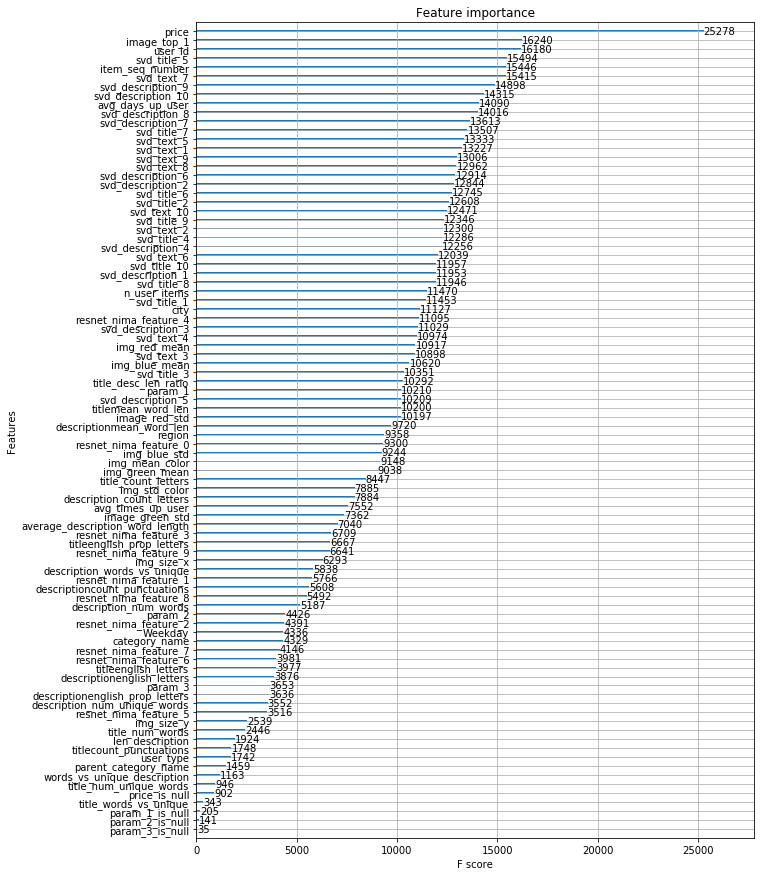

In [51]:
import xgboost as xgb
VALID = True
if VALID == True:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size = 0.06, random_state=23)
    
    tr_data = xgb.DMatrix(X_train, y_train)
    va_data = xgb.DMatrix(X_valid, y_valid)
    
    
    #del X_train, X_valid, y_train, y_valid  ; gc.collect()
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model = xgb.train(params, tr_data, 500, watchlist, maximize=False, early_stopping_rounds = 30, verbose_eval=50)
    
    print("Model Evaluation Stage")
    print('RMSE valid:', np.sqrt(metrics.mean_squared_error(y_valid, model.predict(xgb.DMatrix(X_valid)))))
    print('RMSE train:', np.sqrt(metrics.mean_squared_error(y_train, model.predict(xgb.DMatrix(X_train)))))


else:
    # Go Go Go
    del tr_data, va_data, X_train, X_valid, y_train, y_valid; gc.collect()
    
    tr_data = xgb.DMatrix(X, y)
    model = xgb.train(params,tr_data, 1000, verbose_eval=100)
    

print("Model Evaluation Stage")

lgpred = model.predict(xgb.DMatrix(testing)) 

print('RMSE train:', np.sqrt(metrics.mean_squared_error(y_train, model.predict(xgb.DMatrix(X_train)))))

#Mixing lightgbm with ridge. I haven't really tested if this improves the score or not
#blend = 0.95*lgpred + 0.05*ridge_oof_test[:,0]
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("xgsub_tf.csv",index=True,header=True)
#print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))


import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=[10,15])
xgb.plot_importance(model, ax=ax)

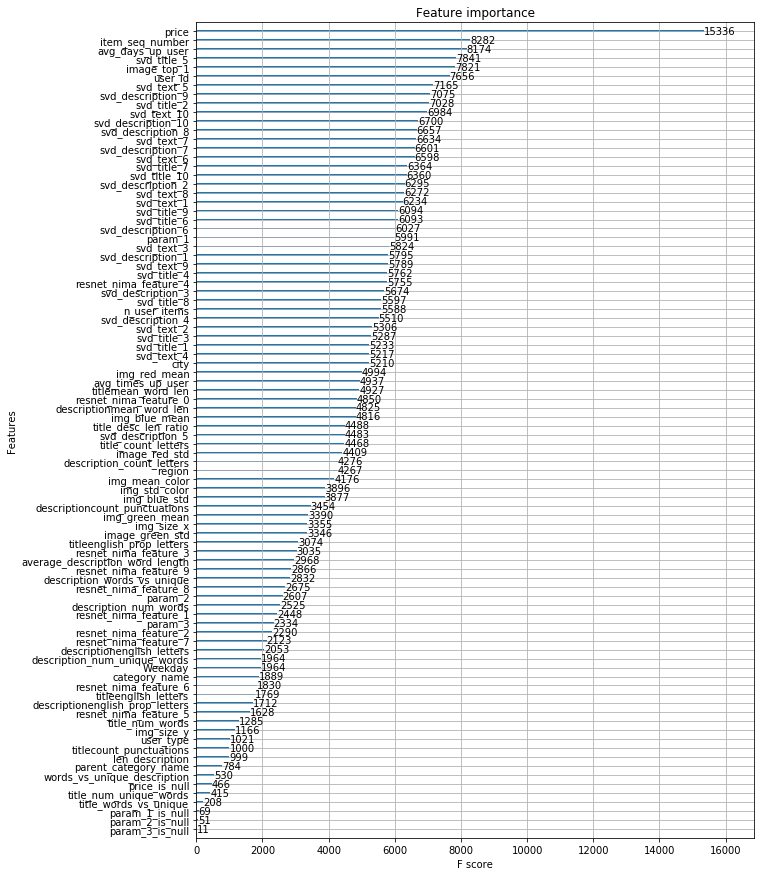

In [40]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=[10,15])
xgb.plot_importance(model, ax=ax )
 

In [ ]:
import datetime
datetime.datetime.now()

In [ ]:
clf.feature_importances_